In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np

import csv
import os
import sys

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.externals import joblib
from sklearn.metrics import log_loss
import xgboost as xgb

import matplotlib.pyplot as plt

In [2]:

# XGBoost params:
xgboost_params = { 
   "objective": "binary:logistic",
   "booster": "gbtree",
   "eval_metric": ["auc","error","map","logloss"],
   "eta": 0.01, # 0.06, #0.01,
   #"min_child_weight": 240,
   "subsample": 0.75,
   "colsample_bytree": 0.68,
   "max_depth": 7
}

print('Load data...')
train = pd.read_csv('data/train.csv')
target = train['target']
train = train.drop(['ID','target'],axis=1)
test = pd.read_csv('data/test.csv')
ids = test['ID'].values
test = test.drop(['ID'],axis=1)
#




Load data...


In [3]:
# Define a function, dummify, that will replace categorical features with dummy columns. Return the new dataset,
# the names of the dummy columns, and the rows with null values for each categorical variable
def dummify(name,series):
    prefix_string = name + '_'
    dummies = pd.get_dummies(series,prefix=prefix_string)
    dummy_column_names = dummies.columns.values
    #Get a list of all rows containing nulls. After dummifying these rows will just have all zeros for dummy variable
    get_nulls = np.where(series.isnull() == True)[0].tolist()

    return dummies, dummy_column_names, get_nulls

In [4]:
# Drop features with > 0.9 correlation. Keep feature with fewest NaNs

corr = train.corr()

to_drop = set()
# for col in corr.columns.values:
#     list_correlated = corr[col][(corr[col] > 0.9) & (corr[col] < 1)].index.tolist()
#     if len(list_correlated) > 0:
#         sys.stdout.write(col + ": ")
#         print list_correlated
for col in corr.columns.values:
    if col in to_drop:
        continue

    col_list = corr[col][(corr[col] > 0.9) & (corr[col] < 1)].index.tolist()
    col_set = set(col_list)
    col_set.difference_update(to_drop)
    if (len(col_list) == 0) or (len(col_set) == 0):
        continue

    col_list.append(col)
    lowest_na_count = train[col_list[0]].isnull().sum()
    best_col = col_list[0]
    for option in col_list:
        na_count = train[option].isnull().sum()
        if na_count < lowest_na_count:
            lowest_na_count = na_count
            best_col = option
    col_list.remove(best_col)
#     print 'dropping = ' + str(col_list)
#     print 'keeping = ' + str(best_col)
    to_drop.update(col_list)


In [5]:
print "Adding features..."
train['NA_num'] = train.isnull().sum(axis=1)
test['NA_num'] = test.isnull().sum(axis=1)

Adding features...


In [14]:


drop_correlated = True

if drop_correlated == True:
    print 'Drop Correlated ...'
    train.drop(list(to_drop),axis=1, inplace = True)
    test.drop(list(to_drop),axis=1, inplace = True)

print('Clearing...')
train_dummy_columns = {}
train_nulls_dict = {}
test_dummy_columns = {}
test_nulls_dict = {}



cleaned_train = train.copy()
cleaned_test = test.copy()





for (train_name, train_series), (test_name, test_series) in zip(train.iteritems(),test.iteritems()):
    if train_name == 'v22':
        #v22 has too many options to dummify, instead: factorize
        cleaned_train[train_name], tmp_indexer = pd.factorize(train[train_name])
        cleaned_test[test_name] = tmp_indexer.get_indexer(test[test_name])
        #but now we have -1 values (NaN)    
    elif train_series.dtype == 'O':
        print 'Dummifying ' + train_name
        cleaned_train.drop(train_name,axis=1,inplace = True)
        cleaned_test.drop(train_name,axis=1,inplace = True)
        
        train_dummies, train_dummy_list, train_null_list = dummify(train_name,train_series)
        test_dummies, test_dummy_list, test_null_list = dummify(test_name,test_series)

        cleaned_train = pd.concat([cleaned_train,train_dummies], axis = 1)
        cleaned_test = pd.concat([cleaned_test,test_dummies], axis = 1)

        train_dummy_columns[train_name] = train_dummy_list
        train_nulls_dict[train_name] = train_null_list
        test_dummy_columns[test_name] = test_dummy_list
        test_nulls_dict[test_name] = test_null_list
        
    else:
        #for int or float: fill NaN
        tmp_len = len(train[train_series.isnull()])
        if tmp_len>0:
            cleaned_train.loc[train_series.isnull(), train_name] = train_series.mean()
        #and Test
        tmp_len = len(test[test_series.isnull()])
        if tmp_len>0:
            cleaned_test.loc[test_series.isnull(), test_name] = train_series.mean()  #TODO

Drop Correlated ...
Clearing...
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125


In [13]:
# cleaned_train.isnull().sum(axis=1)
# with pd.option_context('display.max_rows', 999, 'display.max_columns', 3):
#    print cleaned_train.iloc[0]

v1          1.335739e+00
v2          8.727474e+00
v4          3.921026e+00
v5          7.915266e+00
v6          2.599278e+00
v7          3.176895e+00
v9          9.999999e+00
v10         5.032815e-01
v14         1.163639e+01
v16         8.571429e+00
v18         1.067204e-01
v19         1.488831e-01
v21         7.730923e+00
v22         0.000000e+00
v23        -1.716131e-08
v27         3.393503e+00
v28         5.901219e-01
v35         8.375452e+00
v36         1.132659e+01
v37         4.545457e-01
v38         0.000000e+00
v39         4.012088e+00
v40         7.711453e+00
v42         1.270758e+01
v44         1.049834e+01
v45         9.848672e+00
v48         1.217173e+01
v50         8.994200e-01
v51         7.277792e+00
v53         1.674797e+01
v55         1.299638e+00
v57         3.971118e+00
v58         5.298022e-01
v59         1.089098e+01
v60         1.588448e+00
v61         1.585815e+01
v62         1.000000e+00
v65         1.830393e+01
v68         1.523179e+01
v69         1.714286e+01


Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.727137	valid-error:0.225243	valid-map:0.889918	valid-logloss:0.689398
[50]	valid-auc:0.750837	valid-error:0.219776	valid-map:0.901099	valid-logloss:0.571397
[100]	valid-auc:0.752786	valid-error:0.219776	valid-map:0.902252	valid-logloss:0.518269
[150]	valid-auc:0.754536	valid-error:0.218901	valid-map:0.903377	valid-logloss:0.492845
[200]	valid-auc:0.755700	valid-error:0.218646	valid-map:0.904082	valid-logloss:0.479692
[250]	valid-auc:0.756647	valid-error:0.218173	valid-map:0.904713	valid-logloss:0.473083
[300]	valid-auc:0.757417	valid-error:0.218391	valid-map:0.905198	valid-logloss:0.469453
[350]	valid-auc:0.758166	valid-error:0.217662	valid-map:0.905684	valid-logloss:0.467365
[400]	valid-auc:0.758874	valid-error:0.217589	valid-map:0.906124	valid-logloss:0.465976
[450]	valid-auc:0.759466	valid-error:0.217516	valid-map:0.906501	v

0.767015
0.45865
2478


<IPython.core.display.Javascript object>


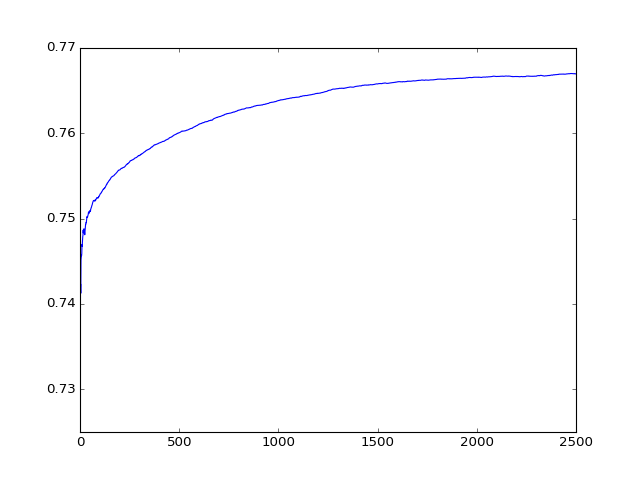

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_train.values, target.values, test_size=0.30, random_state = 1)

X_valid, X_itest, y_valid, y_itest = train_test_split(X_valid, y_valid, test_size=0.20, random_state = 1)

final = False

# xgtrain = xgb.DMatrix(train.values, target.values)
# xgtest = xgb.DMatrix(test.values)

xgtrain = xgb.DMatrix(X_train, y_train)
xgvalid = xgb.DMatrix(X_valid, y_valid)
xgtest = xgb.DMatrix(cleaned_test.values)

if final == True:
    xgtrain = xgb.DMatrix(cleaned_train.values, target.values)
    

#Now let's fit the model
print('Fit the model...')
boost_round = 2500 #1800 CHANGE THIS BEFORE START

filename = 'data/model/xgb-dummy-except-v22.pkl'
if not os.path.exists(filename):
    print 'Training....'
    eval_dict = dict()
    if final == False:
        clf = xgb.train(xgboost_params, xgtrain, num_boost_round=boost_round, verbose_eval=50, maximize=False,
                    evals_result=eval_dict, early_stopping_rounds=100, evals=[(xgvalid, 'valid')])
    else:
    # Use the following when not using validation a.k.a. for final run
        clf = xgb.train(xgboost_params,xgtrain,num_boost_round=boost_round,verbose_eval=True,maximize=False)
    joblib.dump(clf, filename)
else:
    print 'Loading...'
    clf = joblib.load(filename)

# ------------------
#print(eval_dict)
if final == False:
    score_list = [float(s) for s in eval_dict['valid']['auc']]
    print(max(score_list))   # There are best score (max() - for 'auc', but min() for logloss)
    #same result:
    print(clf.best_score) 
    #and best xgboost_round:
    print(clf.best_iteration)


    plt.plot(score_list)
    plt.show()


In [17]:
train_preds = clf.predict(xgb.DMatrix(X_train), ntree_limit=clf.best_iteration)
print('Train score:  ' + str(log_loss(y_train, train_preds)))

valid_preds = clf.predict(xgb.DMatrix(X_valid), ntree_limit=clf.best_iteration)
print('Valid score:  ' + str(log_loss(y_valid, valid_preds)))

itest_preds = clf.predict(xgb.DMatrix(X_itest), ntree_limit=clf.best_iteration)
print('Independent test set score:  ' + str(log_loss(y_itest, itest_preds)))

# Train score:  0.377414274108
# Valid score:  0.459356080264
# Independent test set score:  0.460825726577

Train score:  0.358261040961
Valid score:  0.458651347997
Independent test set score:  0.460001185994


In [19]:

#----------------    
# Code for predicting on test data and saving prediction result
# Make predict
print('Predict...')
filename = 'data/model/xgb-dummy-except-v22.pkl'
clf = joblib.load(filename)
test_preds = clf.predict(xgtest, ntree_limit=clf.best_iteration)
# Save results
#
predictions_file = open("data/team_GAF_result.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["ID", "PredictedProb"])
open_file_object.writerows(zip(ids, test_preds))
predictions_file.close()
#
print('Done.')

Predict...
Done.
